In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dados e pré-processamento

In [ ]:
# https://www.tensorflow.org/datasets/overview
# https://www.tensorflow.org/datasets/catalog/overview
tfds.list_builders()

In [40]:
builder = tfds.builder('rock_paper_scissors')
info = builder.info
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

In [2]:
ds_train = tfds.load(name='rock_paper_scissors',split='train')
ds_test = tfds.load(name='rock_paper_scissors',split='test')

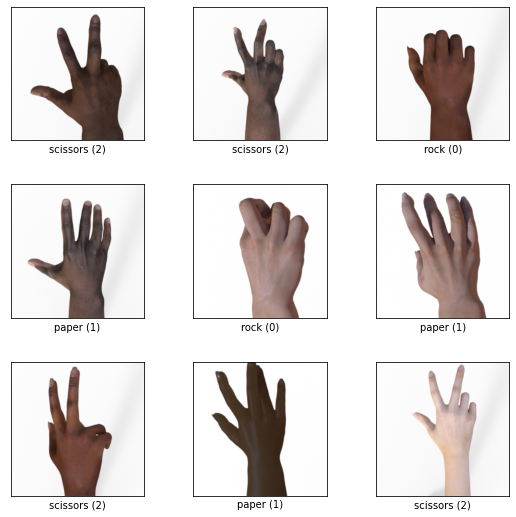

In [41]:
fig = tfds.show_examples(info,ds_train)

In [3]:
# Como as cores não importam, só os formatos, vai pegar só [:,:,0] (só o vermelho), pra ficar em gray scale msm 
train_images = np.array([example['image'].numpy()[:,:,0] for example in ds_train])
train_labels = np.array([example['label'].numpy() for example in ds_train])

test_images = np.array([example['image'].numpy()[:,:,0] for example in ds_test])
test_labels = np.array([example['label'].numpy() for example in ds_test])

In [4]:
#2520 imagens, 300 de largura,300 de altura
print(train_images.shape)
print(test_images.shape)

(2520, 300, 300)
(372, 300, 300)


In [4]:
#Pra CNN precisa de uma dimensão só de cor
train_images = train_images.reshape(2520, 300, 300,1)
test_images = test_images.reshape(372, 300, 300,1)

In [6]:
#Inteiros de 0 até 2^8-1 (255)
train_images.dtype

dtype('uint8')

In [5]:
#Colocando entre 0 e 1
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images /= 255
test_images /= 255

# Rede Neural (básica)

In [ ]:
#Flatten transforma as imagens de 300x300 num só vetor de tamanho 300*300
model = keras.Sequential([
                          keras.layers.Flatten(),
                          keras.layers.Dense(512,activation='relu'),
                          keras.layers.Dense(256,activation='relu'),
                          keras.layers.Dense(3,activation='softmax')
])

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(train_images,train_labels,epochs=5,batch_size=32)

Epoch 1/5
79/79 [==============================] - 21s 260ms/step - loss: 23.1336 - accuracy: 0.4456
Epoch 2/5
79/79 [==============================] - 20s 259ms/step - loss: 3.5050 - accuracy: 0.5020
Epoch 3/5
79/79 [==============================] - 21s 260ms/step - loss: 0.6213 - accuracy: 0.7655
Epoch 4/5
79/79 [==============================] - 21s 260ms/step - loss: 0.4911 - accuracy: 0.8183
Epoch 5/5
79/79 [==============================] - 21s 261ms/step - loss: 0.3076 - accuracy: 0.8857


In [ ]:
# Overfitou pq ta aprendendo pixel por pixel 
model.evaluate(test_images,test_labels)

12/12 [==============================] - 1s 69ms/step - loss: 1.3090 - accuracy: 0.6263


[1.308984398841858, 0.6263440847396851]

# CNN - Básica


In [ ]:
shape = train_images.shape[1:]
model = keras.Sequential([
                          keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu',input_shape=shape),
                          keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
                          keras.layers.Flatten(),
                          keras.layers.Dense(3,activation='softmax')
])

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(train_images,train_labels,epochs=5,batch_size=32)

Epoch 1/5
 2/79 [..............................] - ETA: 6s - loss: 54.9926 - accuracy: 0.3906WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0631s vs `on_train_batch_end` time: 0.1102s). Check your callbacks.


79/79 [==============================] - 14s 176ms/step - loss: 3.4196 - accuracy: 0.6770
Epoch 2/5
79/79 [==============================] - 14s 172ms/step - loss: 0.2563 - accuracy: 0.9413
Epoch 3/5
79/79 [==============================] - 14s 175ms/step - loss: 0.0348 - accuracy: 0.9960
Epoch 4/5
79/79 [==============================] - 14s 177ms/step - loss: 0.0093 - accuracy: 0.9988
Epoch 5/5
79/79 [==============================] - 14s 175ms/step - loss: 0.0045 - accuracy: 1.0000


In [ ]:
# Overfitou de novo
model.evaluate(test_images,test_labels)

12/12 [==============================] - 1s 75ms/step - loss: 1.5086 - accuracy: 0.5000


[1.508592128753662, 0.5]

# CNN - Boa

In [14]:
shape = train_images.shape[1:]
#AveragePooling pega a média dos pixels num grid 6x6 e anda de 3 em 3
#Pooling faz Downsample
#Conv2D faz extração de features
#MaxPool2D pega o maior pixel num grid sizexsize andando de size em size 
                          
model = keras.Sequential([
                          keras.layers.AveragePooling2D(pool_size=(6,6),strides=3,input_shape=shape),
                          keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                          keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
                          keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
                          keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
                          keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
                          keras.layers.MaxPool2D(pool_size=(4,4),strides=4),
                          keras.layers.Dropout(0.5),
                          keras.layers.Flatten(),
                          keras.layers.Dense(128,activation='relu'),
                          keras.layers.Dense(64,activation='relu'),
                          keras.layers.Dense(3,activation='softmax')
])

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(train_images,train_labels,epochs=5,batch_size=32)

Epoch 1/5
79/79 [==============================] - 2s 27ms/step - loss: 0.7147 - accuracy: 0.6456
Epoch 2/5
79/79 [==============================] - 2s 27ms/step - loss: 0.0918 - accuracy: 0.9706
Epoch 3/5
79/79 [==============================] - 2s 26ms/step - loss: 0.0359 - accuracy: 0.9869
Epoch 4/5
79/79 [==============================] - 2s 27ms/step - loss: 0.0166 - accuracy: 0.9956
Epoch 5/5
79/79 [==============================] - 2s 26ms/step - loss: 0.0080 - accuracy: 0.9972


In [31]:
model.evaluate(test_images,test_labels)

12/12 [==============================] - 0s 13ms/step - loss: 0.4118 - accuracy: 0.8763


[0.411830335855484, 0.8763440847396851]

In [30]:
train_images.shape

(2520, 300, 300, 1)

In [16]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_3 (Average (None, 99, 99, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 97, 97, 64)        640       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 95, 95, 32)        18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 32)        9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 43, 43, 16)        4624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 16)       

# Hiperparâmetros(gridsearch)

In [ ]:
pip install -U keras-tuner

In [ ]:
from kerastuner.tuners import RandomSearch

In [ ]:
def build_model(hp):
    model = keras.Sequential()

    model.add(keras.layers.AveragePooling2D(pool_size=(6,6),strides=3,input_shape=shape))

    for i in range(hp.Int('Conv. Layers',min_value=0,max_value=3)):
        model.add(keras.layers.Conv2D(filters=hp.Choice(f'layer_{i}_filters',[16,32,64]), kernel_size=(3,3), activation='relu'))

    model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(
        hp.Choice('Dense Layer',[64,128,256,512,1024]),
        activation='relu'))
    
    model.add(keras.layers.Dense(3,activation='softmax'))

    model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    directory='./novo_modelo')

tuner.search(train_images,train_labels,validation_data=(test_images,test_labels),epochs=10,batch_size=32)

Epoch 1/10
79/79 [==============================] - 2s 25ms/step - loss: 0.9518 - accuracy: 0.6222 - val_loss: 0.8534 - val_accuracy: 0.5941
Epoch 2/10
79/79 [==============================] - 2s 22ms/step - loss: 0.1694 - accuracy: 0.9512 - val_loss: 0.8066 - val_accuracy: 0.6048
Epoch 3/10
79/79 [==============================] - 2s 23ms/step - loss: 0.0597 - accuracy: 0.9853 - val_loss: 0.8506 - val_accuracy: 0.7043
Epoch 4/10
79/79 [==============================] - 2s 21ms/step - loss: 0.0245 - accuracy: 0.9929 - val_loss: 1.0828 - val_accuracy: 0.6640
Epoch 5/10
79/79 [==============================] - 2s 21ms/step - loss: 0.0127 - accuracy: 0.9972 - val_loss: 0.8681 - val_accuracy: 0.7016
Epoch 6/10
79/79 [==============================] - 2s 22ms/step - loss: 0.0087 - accuracy: 0.9980 - val_loss: 0.8747 - val_accuracy: 0.7473
Epoch 7/10
79/79 [==============================] - 2s 23ms/step - loss: 0.0051 - accuracy: 0.9988 - val_loss: 0.8823 - val_accuracy: 0.7500
Epoch 8/10
79

Epoch 1/10
79/79 [==============================] - 2s 20ms/step - loss: 1.2652 - accuracy: 0.6218 - val_loss: 0.9864 - val_accuracy: 0.6398
Epoch 2/10
79/79 [==============================] - 1s 16ms/step - loss: 0.4707 - accuracy: 0.8944 - val_loss: 0.8662 - val_accuracy: 0.6210
Epoch 3/10
79/79 [==============================] - 1s 16ms/step - loss: 0.2192 - accuracy: 0.9647 - val_loss: 0.8104 - val_accuracy: 0.5565
Epoch 4/10
79/79 [==============================] - 1s 19ms/step - loss: 0.1094 - accuracy: 0.9825 - val_loss: 0.8023 - val_accuracy: 0.6694
Epoch 5/10
79/79 [==============================] - 2s 19ms/step - loss: 0.0722 - accuracy: 0.9877 - val_loss: 0.8180 - val_accuracy: 0.6962
Epoch 6/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0468 - accuracy: 0.9925 - val_loss: 0.9102 - val_accuracy: 0.6935
Epoch 7/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0364 - accuracy: 0.9937 - val_loss: 0.8854 - val_accuracy: 0.6882
Epoch 8/10
79

Epoch 1/10
79/79 [==============================] - 1s 11ms/step - loss: 1.3268 - accuracy: 0.3857 - val_loss: 1.0761 - val_accuracy: 0.3602
Epoch 2/10
79/79 [==============================] - 1s 9ms/step - loss: 1.0223 - accuracy: 0.4921 - val_loss: 1.0437 - val_accuracy: 0.4489
Epoch 3/10
79/79 [==============================] - 1s 9ms/step - loss: 0.9230 - accuracy: 0.5508 - val_loss: 1.0046 - val_accuracy: 0.6237
Epoch 4/10
79/79 [==============================] - 1s 9ms/step - loss: 0.8485 - accuracy: 0.6226 - val_loss: 0.9716 - val_accuracy: 0.4301
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.8083 - accuracy: 0.6401 - val_loss: 0.9670 - val_accuracy: 0.5699
Epoch 6/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7505 - accuracy: 0.6821 - val_loss: 1.0010 - val_accuracy: 0.4758
Epoch 7/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7238 - accuracy: 0.6929 - val_loss: 0.9963 - val_accuracy: 0.3925
Epoch 8/10
79/79 [=

Epoch 1/10
79/79 [==============================] - 1s 15ms/step - loss: 1.3641 - accuracy: 0.4139 - val_loss: 1.0682 - val_accuracy: 0.4274
Epoch 2/10
79/79 [==============================] - 1s 13ms/step - loss: 0.9051 - accuracy: 0.6552 - val_loss: 1.0226 - val_accuracy: 0.5108
Epoch 3/10
79/79 [==============================] - 1s 13ms/step - loss: 0.6848 - accuracy: 0.8111 - val_loss: 0.8847 - val_accuracy: 0.6048
Epoch 4/10
79/79 [==============================] - 1s 13ms/step - loss: 0.4817 - accuracy: 0.8615 - val_loss: 0.8438 - val_accuracy: 0.6102
Epoch 5/10
79/79 [==============================] - 1s 17ms/step - loss: 0.3094 - accuracy: 0.9230 - val_loss: 0.7417 - val_accuracy: 0.7366
Epoch 6/10
79/79 [==============================] - 1s 13ms/step - loss: 0.2320 - accuracy: 0.9437 - val_loss: 0.7829 - val_accuracy: 0.6747
Epoch 7/10
79/79 [==============================] - 1s 13ms/step - loss: 0.1822 - accuracy: 0.9548 - val_loss: 0.8118 - val_accuracy: 0.6075
Epoch 8/10
79

Epoch 1/10
79/79 [==============================] - 1s 11ms/step - loss: 1.4635 - accuracy: 0.4183 - val_loss: 1.1617 - val_accuracy: 0.3333
Epoch 2/10
79/79 [==============================] - 1s 9ms/step - loss: 1.0167 - accuracy: 0.4813 - val_loss: 1.0900 - val_accuracy: 0.3548
Epoch 3/10
79/79 [==============================] - 1s 9ms/step - loss: 0.8871 - accuracy: 0.5960 - val_loss: 1.1367 - val_accuracy: 0.3925
Epoch 4/10
79/79 [==============================] - 1s 10ms/step - loss: 0.8192 - accuracy: 0.6325 - val_loss: 1.0868 - val_accuracy: 0.4355
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7900 - accuracy: 0.6488 - val_loss: 0.9797 - val_accuracy: 0.6425
Epoch 6/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7292 - accuracy: 0.6837 - val_loss: 1.0132 - val_accuracy: 0.3548
Epoch 7/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7322 - accuracy: 0.6786 - val_loss: 1.0007 - val_accuracy: 0.4570
Epoch 8/10
79/79 [

Epoch 1/10
79/79 [==============================] - 4s 46ms/step - loss: 0.8687 - accuracy: 0.7274 - val_loss: 0.7956 - val_accuracy: 0.5860
Epoch 2/10
79/79 [==============================] - 4s 46ms/step - loss: 0.0428 - accuracy: 0.9897 - val_loss: 1.0881 - val_accuracy: 0.6613
Epoch 3/10
79/79 [==============================] - 4s 45ms/step - loss: 0.0086 - accuracy: 0.9984 - val_loss: 0.8526 - val_accuracy: 0.7097
Epoch 4/10
79/79 [==============================] - 2s 29ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.0418 - val_accuracy: 0.7043
Epoch 5/10
79/79 [==============================] - 2s 28ms/step - loss: 6.0214e-04 - accuracy: 1.0000 - val_loss: 1.1729 - val_accuracy: 0.7070
Epoch 6/10
79/79 [==============================] - 3s 43ms/step - loss: 5.4984e-04 - accuracy: 1.0000 - val_loss: 1.1759 - val_accuracy: 0.7151
Epoch 7/10
79/79 [==============================] - 4s 52ms/step - loss: 1.5745e-04 - accuracy: 1.0000 - val_loss: 1.1721 - val_accuracy: 0.7204
E

Epoch 1/10
 2/79 [..............................] - ETA: 2s - loss: 8.1286 - accuracy: 0.2969WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0171s vs `on_train_batch_end` time: 0.0372s). Check your callbacks.


79/79 [==============================] - 20s 253ms/step - loss: 1.0931 - accuracy: 0.6734 - val_loss: 0.9406 - val_accuracy: 0.6263
Epoch 2/10
79/79 [==============================] - 24s 308ms/step - loss: 0.1102 - accuracy: 0.9714 - val_loss: 1.3246 - val_accuracy: 0.6774
Epoch 3/10
79/79 [==============================] - 4s 49ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.9765 - val_accuracy: 0.6478
Epoch 4/10
79/79 [==============================] - 4s 48ms/step - loss: 4.9376e-04 - accuracy: 1.0000 - val_loss: 1.8155 - val_accuracy: 0.6425
Epoch 5/10
79/79 [==============================] - 4s 48ms/step - loss: 3.5805e-04 - accuracy: 1.0000 - val_loss: 2.3542 - val_accuracy: 0.6075
Epoch 6/10
79/79 [==============================] - 4s 48ms/step - loss: 1.4128e-04 - accuracy: 1.0000 - val_loss: 2.3577 - val_accuracy: 0.6156
Epoch 7/10
79/79 [==============================] - 4s 48ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.3290 - val_accuracy: 0.5968
Epoch 8/

Epoch 1/10
79/79 [==============================] - 1s 11ms/step - loss: 2.1055 - accuracy: 0.4036 - val_loss: 1.1070 - val_accuracy: 0.3441
Epoch 2/10
79/79 [==============================] - 1s 10ms/step - loss: 0.9518 - accuracy: 0.5452 - val_loss: 1.0426 - val_accuracy: 0.4409
Epoch 3/10
79/79 [==============================] - 1s 10ms/step - loss: 0.8567 - accuracy: 0.6242 - val_loss: 0.9794 - val_accuracy: 0.5323
Epoch 4/10
79/79 [==============================] - 1s 10ms/step - loss: 0.8381 - accuracy: 0.6167 - val_loss: 1.0678 - val_accuracy: 0.4785
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7597 - accuracy: 0.6722 - val_loss: 0.9537 - val_accuracy: 0.4597
Epoch 6/10
79/79 [==============================] - 1s 10ms/step - loss: 0.7271 - accuracy: 0.6774 - val_loss: 1.1923 - val_accuracy: 0.3871
Epoch 7/10
79/79 [==============================] - 1s 10ms/step - loss: 0.7082 - accuracy: 0.6897 - val_loss: 0.9663 - val_accuracy: 0.5538
Epoch 8/10
79/

Epoch 1/10
79/79 [==============================] - 1s 11ms/step - loss: 1.4881 - accuracy: 0.4012 - val_loss: 1.1631 - val_accuracy: 0.3333
Epoch 2/10
79/79 [==============================] - 1s 10ms/step - loss: 1.0075 - accuracy: 0.4944 - val_loss: 1.1333 - val_accuracy: 0.4462
Epoch 3/10
79/79 [==============================] - 1s 10ms/step - loss: 0.8763 - accuracy: 0.6008 - val_loss: 0.9739 - val_accuracy: 0.5430
Epoch 4/10
79/79 [==============================] - 1s 9ms/step - loss: 0.8202 - accuracy: 0.6266 - val_loss: 1.0306 - val_accuracy: 0.3978
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7352 - accuracy: 0.6897 - val_loss: 1.0326 - val_accuracy: 0.5108
Epoch 6/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7228 - accuracy: 0.6881 - val_loss: 1.0296 - val_accuracy: 0.4973
Epoch 7/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7299 - accuracy: 0.6794 - val_loss: 0.9423 - val_accuracy: 0.6425
Epoch 8/10
79/79 

Epoch 1/10
 2/79 [..............................] - ETA: 2s - loss: 29.7101 - accuracy: 0.4375WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0211s vs `on_train_batch_end` time: 0.0532s). Check your callbacks.


79/79 [==============================] - 17s 219ms/step - loss: 2.2782 - accuracy: 0.5278 - val_loss: 0.8485 - val_accuracy: 0.6747
Epoch 2/10
79/79 [==============================] - 43s 541ms/step - loss: 0.1833 - accuracy: 0.9496 - val_loss: 0.7594 - val_accuracy: 0.7312
Epoch 3/10
79/79 [==============================] - 42s 530ms/step - loss: 0.0463 - accuracy: 0.9877 - val_loss: 0.6600 - val_accuracy: 0.7930
Epoch 4/10
79/79 [==============================] - 6s 75ms/step - loss: 0.0359 - accuracy: 0.9893 - val_loss: 0.9752 - val_accuracy: 0.6075
Epoch 5/10
79/79 [==============================] - 6s 74ms/step - loss: 0.0984 - accuracy: 0.9714 - val_loss: 1.0003 - val_accuracy: 0.6989
Epoch 6/10
79/79 [==============================] - 6s 74ms/step - loss: 0.0082 - accuracy: 0.9988 - val_loss: 1.1616 - val_accuracy: 0.6882
Epoch 7/10
79/79 [==============================] - 6s 74ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 1.3874 - val_accuracy: 0.6828
Epoch 8/10
79/79 [

Epoch 1/10
79/79 [==============================] - 1s 11ms/step - loss: 1.5763 - accuracy: 0.4127 - val_loss: 1.1049 - val_accuracy: 0.4355
Epoch 2/10
79/79 [==============================] - 1s 9ms/step - loss: 0.9250 - accuracy: 0.5599 - val_loss: 0.9872 - val_accuracy: 0.4247
Epoch 3/10
79/79 [==============================] - 1s 9ms/step - loss: 0.8407 - accuracy: 0.6155 - val_loss: 1.0724 - val_accuracy: 0.5161
Epoch 4/10
79/79 [==============================] - 1s 10ms/step - loss: 0.7867 - accuracy: 0.6504 - val_loss: 1.1468 - val_accuracy: 0.4086
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7384 - accuracy: 0.6825 - val_loss: 1.0849 - val_accuracy: 0.4785
Epoch 6/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7686 - accuracy: 0.6500 - val_loss: 1.0018 - val_accuracy: 0.5618
Epoch 7/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7182 - accuracy: 0.6841 - val_loss: 1.1141 - val_accuracy: 0.3978
Epoch 8/10
79/79 [

Epoch 1/10
 2/79 [..............................] - ETA: 2s - loss: 7.6260 - accuracy: 0.3594WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0169s vs `on_train_batch_end` time: 0.0377s). Check your callbacks.


79/79 [==============================] - 8s 96ms/step - loss: 1.1820 - accuracy: 0.6706 - val_loss: 0.7127 - val_accuracy: 0.7473
Epoch 2/10
79/79 [==============================] - 4s 52ms/step - loss: 0.0588 - accuracy: 0.9857 - val_loss: 0.8196 - val_accuracy: 0.7312
Epoch 3/10
79/79 [==============================] - 4s 51ms/step - loss: 0.0118 - accuracy: 0.9988 - val_loss: 0.8163 - val_accuracy: 0.7419
Epoch 4/10
79/79 [==============================] - 4s 52ms/step - loss: 0.0112 - accuracy: 0.9972 - val_loss: 1.2187 - val_accuracy: 0.6532
Epoch 5/10
79/79 [==============================] - 4s 52ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 1.0131 - val_accuracy: 0.6909
Epoch 6/10
79/79 [==============================] - 4s 52ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 1.2528 - val_accuracy: 0.7258
Epoch 7/10
79/79 [==============================] - 4s 53ms/step - loss: 6.1295e-04 - accuracy: 1.0000 - val_loss: 1.3514 - val_accuracy: 0.7043
Epoch 8/10
79/79 [==

Epoch 1/10
 1/79 [..............................] - ETA: 0s - loss: 1.1349 - accuracy: 0.2812WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0101s vs `on_train_batch_end` time: 0.0181s). Check your callbacks.


79/79 [==============================] - 6s 74ms/step - loss: 1.1169 - accuracy: 0.7675 - val_loss: 0.8368 - val_accuracy: 0.6290
Epoch 2/10
79/79 [==============================] - 9s 115ms/step - loss: 0.0349 - accuracy: 0.9909 - val_loss: 1.1103 - val_accuracy: 0.6720
Epoch 3/10
79/79 [==============================] - 3s 34ms/step - loss: 0.0149 - accuracy: 0.9956 - val_loss: 1.6394 - val_accuracy: 0.6022
Epoch 4/10
79/79 [==============================] - 3s 33ms/step - loss: 0.0114 - accuracy: 0.9960 - val_loss: 1.9665 - val_accuracy: 0.5914
Epoch 5/10
79/79 [==============================] - 3s 32ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 1.9503 - val_accuracy: 0.6210
Epoch 6/10
79/79 [==============================] - 3s 33ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.9592 - val_accuracy: 0.6290
Epoch 7/10
79/79 [==============================] - 3s 33ms/step - loss: 4.2301e-04 - accuracy: 1.0000 - val_loss: 2.3134 - val_accuracy: 0.6129
Epoch 8/10
79/79 [=

Epoch 1/10
79/79 [==============================] - 1s 10ms/step - loss: 1.2694 - accuracy: 0.3603 - val_loss: 1.0899 - val_accuracy: 0.3817
Epoch 2/10
79/79 [==============================] - 1s 9ms/step - loss: 1.0470 - accuracy: 0.4270 - val_loss: 1.0820 - val_accuracy: 0.4435
Epoch 3/10
79/79 [==============================] - 1s 9ms/step - loss: 1.0127 - accuracy: 0.4548 - val_loss: 1.0621 - val_accuracy: 0.4328
Epoch 4/10
79/79 [==============================] - 1s 9ms/step - loss: 0.9802 - accuracy: 0.4837 - val_loss: 1.0500 - val_accuracy: 0.4866
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.9507 - accuracy: 0.5099 - val_loss: 1.0346 - val_accuracy: 0.3333
Epoch 6/10
79/79 [==============================] - 1s 9ms/step - loss: 0.9418 - accuracy: 0.5190 - val_loss: 1.0657 - val_accuracy: 0.5349
Epoch 7/10
79/79 [==============================] - 1s 9ms/step - loss: 0.9186 - accuracy: 0.5294 - val_loss: 1.0178 - val_accuracy: 0.4543
Epoch 8/10
79/79 [=

Epoch 1/10
 2/79 [..............................] - ETA: 2s - loss: 17.4587 - accuracy: 0.3750WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0460s). Check your callbacks.


79/79 [==============================] - 19s 241ms/step - loss: 2.9593 - accuracy: 0.6762 - val_loss: 0.8320 - val_accuracy: 0.6210
Epoch 2/10
79/79 [==============================] - 47s 597ms/step - loss: 0.2176 - accuracy: 0.9631 - val_loss: 0.7717 - val_accuracy: 0.6425
Epoch 3/10
79/79 [==============================] - 44s 561ms/step - loss: 0.0638 - accuracy: 0.9913 - val_loss: 0.7215 - val_accuracy: 0.7177
Epoch 4/10
79/79 [==============================] - 4s 53ms/step - loss: 0.0319 - accuracy: 0.9952 - val_loss: 0.8114 - val_accuracy: 0.6935
Epoch 5/10
79/79 [==============================] - 4s 50ms/step - loss: 0.0170 - accuracy: 0.9988 - val_loss: 0.8365 - val_accuracy: 0.6747
Epoch 6/10
79/79 [==============================] - 4s 53ms/step - loss: 0.0121 - accuracy: 0.9996 - val_loss: 0.9266 - val_accuracy: 0.7070
Epoch 7/10
79/79 [==============================] - 4s 52ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.9551 - val_accuracy: 0.6962
Epoch 8/10
79/79 [

Epoch 1/10
79/79 [==============================] - 1s 11ms/step - loss: 1.4901 - accuracy: 0.4210 - val_loss: 1.0622 - val_accuracy: 0.5054
Epoch 2/10
79/79 [==============================] - 1s 9ms/step - loss: 0.9508 - accuracy: 0.5317 - val_loss: 1.4525 - val_accuracy: 0.3333
Epoch 3/10
79/79 [==============================] - 1s 9ms/step - loss: 0.8770 - accuracy: 0.5833 - val_loss: 0.9799 - val_accuracy: 0.5457
Epoch 4/10
79/79 [==============================] - 1s 9ms/step - loss: 0.8084 - accuracy: 0.6369 - val_loss: 0.9554 - val_accuracy: 0.5591
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7535 - accuracy: 0.6730 - val_loss: 1.0276 - val_accuracy: 0.4785
Epoch 6/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7167 - accuracy: 0.6917 - val_loss: 0.9372 - val_accuracy: 0.5215
Epoch 7/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7002 - accuracy: 0.7111 - val_loss: 0.9437 - val_accuracy: 0.5161
Epoch 8/10
79/79 [=

Epoch 1/10
79/79 [==============================] - 2s 23ms/step - loss: 0.9723 - accuracy: 0.6853 - val_loss: 1.0125 - val_accuracy: 0.5269
Epoch 2/10
79/79 [==============================] - 2s 21ms/step - loss: 0.1521 - accuracy: 0.9722 - val_loss: 0.8573 - val_accuracy: 0.6398
Epoch 3/10
79/79 [==============================] - 2s 22ms/step - loss: 0.0348 - accuracy: 0.9940 - val_loss: 0.8592 - val_accuracy: 0.7016
Epoch 4/10
79/79 [==============================] - 2s 22ms/step - loss: 0.0134 - accuracy: 0.9980 - val_loss: 0.8402 - val_accuracy: 0.7258
Epoch 5/10
79/79 [==============================] - 1s 19ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.9509 - val_accuracy: 0.7151
Epoch 6/10
79/79 [==============================] - 1s 18ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.0814 - val_accuracy: 0.7016
Epoch 7/10
79/79 [==============================] - 1s 19ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.0960 - val_accuracy: 0.7097
Epoch 8/10
79

Epoch 1/10
79/79 [==============================] - 1s 11ms/step - loss: 1.9237 - accuracy: 0.4456 - val_loss: 1.1679 - val_accuracy: 0.3333
Epoch 2/10
79/79 [==============================] - 1s 10ms/step - loss: 0.8978 - accuracy: 0.5813 - val_loss: 1.2422 - val_accuracy: 0.3414
Epoch 3/10
79/79 [==============================] - 1s 10ms/step - loss: 0.8116 - accuracy: 0.6421 - val_loss: 1.0465 - val_accuracy: 0.3790
Epoch 4/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7844 - accuracy: 0.6552 - val_loss: 1.2145 - val_accuracy: 0.3387
Epoch 5/10
79/79 [==============================] - 1s 10ms/step - loss: 0.7560 - accuracy: 0.6738 - val_loss: 0.9448 - val_accuracy: 0.6344
Epoch 6/10
79/79 [==============================] - 1s 10ms/step - loss: 0.7230 - accuracy: 0.6877 - val_loss: 1.0081 - val_accuracy: 0.5296
Epoch 7/10
79/79 [==============================] - 1s 10ms/step - loss: 0.6747 - accuracy: 0.7171 - val_loss: 1.0943 - val_accuracy: 0.4624
Epoch 8/10
79/

Epoch 1/10
79/79 [==============================] - 4s 46ms/step - loss: 2.0974 - accuracy: 0.6857 - val_loss: 1.0706 - val_accuracy: 0.4355
Epoch 2/10
79/79 [==============================] - 4s 46ms/step - loss: 0.1945 - accuracy: 0.9583 - val_loss: 0.6834 - val_accuracy: 0.7151
Epoch 3/10
79/79 [==============================] - 4s 45ms/step - loss: 0.0771 - accuracy: 0.9909 - val_loss: 0.6874 - val_accuracy: 0.7204
Epoch 4/10
79/79 [==============================] - 2s 28ms/step - loss: 0.0404 - accuracy: 0.9956 - val_loss: 0.7435 - val_accuracy: 0.6855
Epoch 5/10
79/79 [==============================] - 4s 48ms/step - loss: 0.0261 - accuracy: 0.9972 - val_loss: 0.7422 - val_accuracy: 0.7446
Epoch 6/10
79/79 [==============================] - 2s 28ms/step - loss: 0.0190 - accuracy: 0.9984 - val_loss: 0.7542 - val_accuracy: 0.7151
Epoch 7/10
79/79 [==============================] - 2s 28ms/step - loss: 0.0122 - accuracy: 0.9988 - val_loss: 0.7697 - val_accuracy: 0.7258
Epoch 8/10
79

Epoch 1/10
79/79 [==============================] - 4s 44ms/step - loss: 0.7010 - accuracy: 0.7190 - val_loss: 0.8682 - val_accuracy: 0.6882
Epoch 2/10
79/79 [==============================] - 3s 42ms/step - loss: 0.0778 - accuracy: 0.9790 - val_loss: 0.9563 - val_accuracy: 0.7204
Epoch 3/10
79/79 [==============================] - 3s 36ms/step - loss: 0.0177 - accuracy: 0.9937 - val_loss: 1.2080 - val_accuracy: 0.6989
Epoch 4/10
79/79 [==============================] - 3s 36ms/step - loss: 0.1445 - accuracy: 0.9536 - val_loss: 1.4453 - val_accuracy: 0.6425
Epoch 5/10
79/79 [==============================] - 3s 36ms/step - loss: 0.1929 - accuracy: 0.9183 - val_loss: 1.8757 - val_accuracy: 0.7043
Epoch 6/10
79/79 [==============================] - 3s 36ms/step - loss: 0.0303 - accuracy: 0.9944 - val_loss: 2.3307 - val_accuracy: 0.6774
Epoch 7/10
79/79 [==============================] - 3s 36ms/step - loss: 0.5230 - accuracy: 0.7758 - val_loss: 1.1949 - val_accuracy: 0.6183
Epoch 8/10
79

Epoch 1/10
79/79 [==============================] - 2s 23ms/step - loss: 1.8158 - accuracy: 0.5440 - val_loss: 0.9704 - val_accuracy: 0.4919
Epoch 2/10
79/79 [==============================] - 2s 23ms/step - loss: 0.4611 - accuracy: 0.8937 - val_loss: 0.7717 - val_accuracy: 0.7473
Epoch 3/10
79/79 [==============================] - 1s 16ms/step - loss: 0.2151 - accuracy: 0.9631 - val_loss: 0.7128 - val_accuracy: 0.6989
Epoch 4/10
79/79 [==============================] - 1s 16ms/step - loss: 0.1079 - accuracy: 0.9849 - val_loss: 0.8095 - val_accuracy: 0.5645
Epoch 5/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0635 - accuracy: 0.9909 - val_loss: 0.6755 - val_accuracy: 0.7392
Epoch 6/10
79/79 [==============================] - 2s 21ms/step - loss: 0.0465 - accuracy: 0.9929 - val_loss: 0.6891 - val_accuracy: 0.7581
Epoch 7/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0366 - accuracy: 0.9948 - val_loss: 0.8303 - val_accuracy: 0.6667
Epoch 8/10
79

Epoch 1/10
79/79 [==============================] - 4s 54ms/step - loss: 0.6970 - accuracy: 0.7571 - val_loss: 0.7950 - val_accuracy: 0.7124
Epoch 2/10
79/79 [==============================] - 3s 37ms/step - loss: 0.0446 - accuracy: 0.9901 - val_loss: 1.0130 - val_accuracy: 0.7043
Epoch 3/10
79/79 [==============================] - 4s 52ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.6140 - val_accuracy: 0.7231
Epoch 4/10
79/79 [==============================] - 3s 37ms/step - loss: 5.4303e-04 - accuracy: 1.0000 - val_loss: 1.6910 - val_accuracy: 0.6989
Epoch 5/10
79/79 [==============================] - 3s 37ms/step - loss: 2.4830e-04 - accuracy: 1.0000 - val_loss: 1.8101 - val_accuracy: 0.6882
Epoch 6/10
79/79 [==============================] - 3s 36ms/step - loss: 1.4021e-04 - accuracy: 1.0000 - val_loss: 1.9766 - val_accuracy: 0.6935
Epoch 7/10
79/79 [==============================] - 3s 37ms/step - loss: 9.9613e-05 - accuracy: 1.0000 - val_loss: 2.2462 - val_accuracy: 0.68

Epoch 1/10
79/79 [==============================] - 3s 34ms/step - loss: 1.3208 - accuracy: 0.6060 - val_loss: 0.8655 - val_accuracy: 0.5457
Epoch 2/10
79/79 [==============================] - 2s 32ms/step - loss: 0.1808 - accuracy: 0.9567 - val_loss: 0.7641 - val_accuracy: 0.7043
Epoch 3/10
79/79 [==============================] - 3s 32ms/step - loss: 0.0268 - accuracy: 0.9948 - val_loss: 0.8979 - val_accuracy: 0.7097
Epoch 4/10
79/79 [==============================] - 2s 26ms/step - loss: 0.0133 - accuracy: 0.9972 - val_loss: 0.9915 - val_accuracy: 0.7043
Epoch 5/10
79/79 [==============================] - 2s 26ms/step - loss: 0.0047 - accuracy: 0.9996 - val_loss: 1.1365 - val_accuracy: 0.7097
Epoch 6/10
79/79 [==============================] - 3s 32ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.2314 - val_accuracy: 0.7151
Epoch 7/10
79/79 [==============================] - 2s 26ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.2674 - val_accuracy: 0.7043
Epoch 8/10
79

Epoch 1/10
 1/79 [..............................] - ETA: 0s - loss: 1.1486 - accuracy: 0.2500WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0091s vs `on_train_batch_end` time: 0.0163s). Check your callbacks.


79/79 [==============================] - 6s 77ms/step - loss: 1.8758 - accuracy: 0.7278 - val_loss: 0.8572 - val_accuracy: 0.5780
Epoch 2/10
79/79 [==============================] - 10s 127ms/step - loss: 0.1261 - accuracy: 0.9730 - val_loss: 0.6687 - val_accuracy: 0.7231
Epoch 3/10
79/79 [==============================] - 3s 32ms/step - loss: 0.0529 - accuracy: 0.9913 - val_loss: 0.7838 - val_accuracy: 0.6425
Epoch 4/10
79/79 [==============================] - 24s 309ms/step - loss: 0.0256 - accuracy: 0.9968 - val_loss: 0.7607 - val_accuracy: 0.7339
Epoch 5/10
79/79 [==============================] - 2s 31ms/step - loss: 0.0178 - accuracy: 0.9980 - val_loss: 0.7571 - val_accuracy: 0.7258
Epoch 6/10
79/79 [==============================] - 2s 31ms/step - loss: 0.0121 - accuracy: 0.9984 - val_loss: 0.8090 - val_accuracy: 0.7231
Epoch 7/10
79/79 [==============================] - 2s 31ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.8358 - val_accuracy: 0.7258
Epoch 8/10
79/79 [==

Epoch 1/10
79/79 [==============================] - 1s 10ms/step - loss: 1.1983 - accuracy: 0.4079 - val_loss: 1.0450 - val_accuracy: 0.4435
Epoch 2/10
79/79 [==============================] - 1s 9ms/step - loss: 0.9859 - accuracy: 0.4996 - val_loss: 1.0406 - val_accuracy: 0.4543
Epoch 3/10
79/79 [==============================] - 1s 9ms/step - loss: 0.8835 - accuracy: 0.5913 - val_loss: 1.2128 - val_accuracy: 0.3414
Epoch 4/10
79/79 [==============================] - 1s 9ms/step - loss: 0.8261 - accuracy: 0.6329 - val_loss: 1.0187 - val_accuracy: 0.5000
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7874 - accuracy: 0.6460 - val_loss: 0.9531 - val_accuracy: 0.5511
Epoch 6/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7201 - accuracy: 0.6881 - val_loss: 0.9542 - val_accuracy: 0.5565
Epoch 7/10
79/79 [==============================] - 1s 9ms/step - loss: 0.6893 - accuracy: 0.7083 - val_loss: 0.9420 - val_accuracy: 0.5403
Epoch 8/10
79/79 [=

Epoch 1/10
79/79 [==============================] - 2s 25ms/step - loss: 0.9368 - accuracy: 0.6337 - val_loss: 0.8035 - val_accuracy: 0.6398
Epoch 2/10
79/79 [==============================] - 2s 22ms/step - loss: 0.2111 - accuracy: 0.9464 - val_loss: 0.8936 - val_accuracy: 0.6478
Epoch 3/10
79/79 [==============================] - 2s 23ms/step - loss: 0.0932 - accuracy: 0.9758 - val_loss: 0.8956 - val_accuracy: 0.6774
Epoch 4/10
79/79 [==============================] - 2s 20ms/step - loss: 0.1203 - accuracy: 0.9659 - val_loss: 1.1806 - val_accuracy: 0.6290
Epoch 5/10
79/79 [==============================] - 2s 21ms/step - loss: 0.0617 - accuracy: 0.9821 - val_loss: 1.0488 - val_accuracy: 0.6344
Epoch 6/10
79/79 [==============================] - 2s 21ms/step - loss: 0.0531 - accuracy: 0.9841 - val_loss: 1.4079 - val_accuracy: 0.6237
Epoch 7/10
79/79 [==============================] - 2s 20ms/step - loss: 0.0411 - accuracy: 0.9865 - val_loss: 1.2895 - val_accuracy: 0.6371
Epoch 8/10
79

Epoch 1/10
79/79 [==============================] - 1s 10ms/step - loss: 1.3891 - accuracy: 0.4397 - val_loss: 1.1130 - val_accuracy: 0.4597
Epoch 2/10
79/79 [==============================] - 1s 9ms/step - loss: 0.8943 - accuracy: 0.5810 - val_loss: 1.0437 - val_accuracy: 0.4731
Epoch 3/10
79/79 [==============================] - 1s 10ms/step - loss: 0.8103 - accuracy: 0.6298 - val_loss: 0.9670 - val_accuracy: 0.4839
Epoch 4/10
79/79 [==============================] - 1s 10ms/step - loss: 0.7615 - accuracy: 0.6683 - val_loss: 1.0023 - val_accuracy: 0.5215
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7035 - accuracy: 0.6968 - val_loss: 1.0646 - val_accuracy: 0.4812
Epoch 6/10
79/79 [==============================] - 1s 10ms/step - loss: 0.7128 - accuracy: 0.6881 - val_loss: 0.9703 - val_accuracy: 0.5269
Epoch 7/10
79/79 [==============================] - 1s 10ms/step - loss: 0.6849 - accuracy: 0.7036 - val_loss: 0.9674 - val_accuracy: 0.6398
Epoch 8/10
79/7

Epoch 1/10
 2/79 [..............................] - ETA: 2s - loss: 6.7198 - accuracy: 0.4219WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0429s). Check your callbacks.


79/79 [==============================] - 20s 253ms/step - loss: 4.6326 - accuracy: 0.5762 - val_loss: 0.9453 - val_accuracy: 0.5645
Epoch 2/10
79/79 [==============================] - 45s 569ms/step - loss: 0.4239 - accuracy: 0.8806 - val_loss: 0.7129 - val_accuracy: 0.7177
Epoch 3/10
79/79 [==============================] - 45s 575ms/step - loss: 0.1785 - accuracy: 0.9671 - val_loss: 0.6724 - val_accuracy: 0.7876
Epoch 4/10
79/79 [==============================] - 4s 53ms/step - loss: 0.0832 - accuracy: 0.9885 - val_loss: 0.6757 - val_accuracy: 0.7285
Epoch 5/10
79/79 [==============================] - 4s 53ms/step - loss: 0.0546 - accuracy: 0.9940 - val_loss: 0.6813 - val_accuracy: 0.6909
Epoch 6/10
79/79 [==============================] - 4s 51ms/step - loss: 0.0306 - accuracy: 0.9960 - val_loss: 0.7888 - val_accuracy: 0.6398
Epoch 7/10
79/79 [==============================] - 4s 53ms/step - loss: 0.0227 - accuracy: 0.9964 - val_loss: 0.7215 - val_accuracy: 0.7339
Epoch 8/10
79/79 [

Epoch 1/10
79/79 [==============================] - 2s 29ms/step - loss: 0.8119 - accuracy: 0.6917 - val_loss: 0.7526 - val_accuracy: 0.7554
Epoch 2/10
79/79 [==============================] - 2s 24ms/step - loss: 0.1505 - accuracy: 0.9687 - val_loss: 0.7136 - val_accuracy: 0.7258
Epoch 3/10
79/79 [==============================] - 2s 24ms/step - loss: 0.0550 - accuracy: 0.9853 - val_loss: 0.9268 - val_accuracy: 0.6801
Epoch 4/10
79/79 [==============================] - 2s 24ms/step - loss: 0.0256 - accuracy: 0.9952 - val_loss: 0.8207 - val_accuracy: 0.7177
Epoch 5/10
79/79 [==============================] - 2s 24ms/step - loss: 0.0347 - accuracy: 0.9921 - val_loss: 1.1737 - val_accuracy: 0.7070
Epoch 6/10
79/79 [==============================] - 2s 24ms/step - loss: 0.0157 - accuracy: 0.9968 - val_loss: 1.0588 - val_accuracy: 0.7419
Epoch 7/10
79/79 [==============================] - 2s 24ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 1.0999 - val_accuracy: 0.7151
Epoch 8/10
79

Epoch 1/10
79/79 [==============================] - 1s 11ms/step - loss: 1.9661 - accuracy: 0.4222 - val_loss: 1.0514 - val_accuracy: 0.4194
Epoch 2/10
79/79 [==============================] - 1s 10ms/step - loss: 0.9196 - accuracy: 0.5722 - val_loss: 0.9947 - val_accuracy: 0.6478
Epoch 3/10
79/79 [==============================] - 1s 10ms/step - loss: 0.8590 - accuracy: 0.6036 - val_loss: 0.9768 - val_accuracy: 0.4866
Epoch 4/10
79/79 [==============================] - 1s 10ms/step - loss: 0.7684 - accuracy: 0.6694 - val_loss: 1.0045 - val_accuracy: 0.4516
Epoch 5/10
79/79 [==============================] - 1s 10ms/step - loss: 0.7620 - accuracy: 0.6698 - val_loss: 0.9619 - val_accuracy: 0.5134
Epoch 6/10
79/79 [==============================] - 1s 10ms/step - loss: 0.7218 - accuracy: 0.6968 - val_loss: 0.9657 - val_accuracy: 0.5134
Epoch 7/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7085 - accuracy: 0.6774 - val_loss: 0.9447 - val_accuracy: 0.5161
Epoch 8/10
79/

Epoch 1/10
79/79 [==============================] - 3s 41ms/step - loss: 2.2443 - accuracy: 0.5369 - val_loss: 0.9645 - val_accuracy: 0.7204
Epoch 2/10
79/79 [==============================] - 3s 40ms/step - loss: 0.4784 - accuracy: 0.8972 - val_loss: 0.7835 - val_accuracy: 0.7312
Epoch 3/10
79/79 [==============================] - 3s 41ms/step - loss: 0.2067 - accuracy: 0.9722 - val_loss: 0.6959 - val_accuracy: 0.7581
Epoch 4/10
79/79 [==============================] - 2s 22ms/step - loss: 0.1007 - accuracy: 0.9857 - val_loss: 0.7136 - val_accuracy: 0.6801
Epoch 5/10
79/79 [==============================] - 2s 22ms/step - loss: 0.0613 - accuracy: 0.9901 - val_loss: 0.7096 - val_accuracy: 0.7124
Epoch 6/10
79/79 [==============================] - 2s 22ms/step - loss: 0.0381 - accuracy: 0.9948 - val_loss: 0.7253 - val_accuracy: 0.7473
Epoch 7/10
79/79 [==============================] - 2s 21ms/step - loss: 0.0242 - accuracy: 0.9956 - val_loss: 0.7687 - val_accuracy: 0.7419
Epoch 8/10
79

Epoch 1/10
79/79 [==============================] - 1s 10ms/step - loss: 1.4380 - accuracy: 0.4179 - val_loss: 1.1786 - val_accuracy: 0.3333
Epoch 2/10
79/79 [==============================] - 1s 9ms/step - loss: 0.9709 - accuracy: 0.5198 - val_loss: 1.1319 - val_accuracy: 0.3441
Epoch 3/10
79/79 [==============================] - 1s 9ms/step - loss: 0.8772 - accuracy: 0.6079 - val_loss: 1.0455 - val_accuracy: 0.3522
Epoch 4/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7981 - accuracy: 0.6361 - val_loss: 0.9606 - val_accuracy: 0.5349
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7398 - accuracy: 0.6865 - val_loss: 0.9936 - val_accuracy: 0.4677
Epoch 6/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7368 - accuracy: 0.6833 - val_loss: 1.1323 - val_accuracy: 0.4113
Epoch 7/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7022 - accuracy: 0.7060 - val_loss: 1.0807 - val_accuracy: 0.4704
Epoch 8/10
79/79 [=

Epoch 1/10
 2/79 [..............................] - ETA: 1s - loss: 1.3190 - accuracy: 0.3594WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_train_batch_end` time: 0.0290s). Check your callbacks.


79/79 [==============================] - 3s 43ms/step - loss: 0.6090 - accuracy: 0.7230 - val_loss: 0.8756 - val_accuracy: 0.6882
Epoch 2/10
79/79 [==============================] - 3s 41ms/step - loss: 0.0436 - accuracy: 0.9865 - val_loss: 0.9071 - val_accuracy: 0.7258
Epoch 3/10
79/79 [==============================] - 3s 40ms/step - loss: 0.0064 - accuracy: 0.9984 - val_loss: 1.0117 - val_accuracy: 0.7527
Epoch 4/10
79/79 [==============================] - 3s 38ms/step - loss: 0.0026 - accuracy: 0.9996 - val_loss: 1.2244 - val_accuracy: 0.6989
Epoch 5/10
79/79 [==============================] - 3s 40ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.9699 - val_accuracy: 0.7581
Epoch 6/10
79/79 [==============================] - 3s 38ms/step - loss: 3.1103e-04 - accuracy: 1.0000 - val_loss: 1.2301 - val_accuracy: 0.7366
Epoch 7/10
79/79 [==============================] - 3s 37ms/step - loss: 1.1467e-04 - accuracy: 1.0000 - val_loss: 1.3549 - val_accuracy: 0.7339
Epoch 8/10
79/79

Epoch 1/10
79/79 [==============================] - 3s 34ms/step - loss: 1.0755 - accuracy: 0.4516 - val_loss: 0.9658 - val_accuracy: 0.5511
Epoch 2/10
79/79 [==============================] - 3s 33ms/step - loss: 0.3045 - accuracy: 0.9095 - val_loss: 0.6504 - val_accuracy: 0.7688
Epoch 3/10
79/79 [==============================] - 3s 34ms/step - loss: 0.0467 - accuracy: 0.9885 - val_loss: 0.6545 - val_accuracy: 0.7796
Epoch 4/10
79/79 [==============================] - 2s 31ms/step - loss: 0.0092 - accuracy: 0.9980 - val_loss: 0.7305 - val_accuracy: 0.7796
Epoch 5/10
79/79 [==============================] - 2s 31ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.9179 - val_accuracy: 0.7688
Epoch 6/10
79/79 [==============================] - 2s 31ms/step - loss: 0.0125 - accuracy: 0.9960 - val_loss: 1.3544 - val_accuracy: 0.6452
Epoch 7/10
79/79 [==============================] - 2s 31ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.0622 - val_accuracy: 0.7312
Epoch 8/10
79

Epoch 1/10
79/79 [==============================] - 3s 32ms/step - loss: 1.1025 - accuracy: 0.6647 - val_loss: 1.0391 - val_accuracy: 0.5403
Epoch 2/10
79/79 [==============================] - 2s 31ms/step - loss: 0.1782 - accuracy: 0.9619 - val_loss: 0.7931 - val_accuracy: 0.6962
Epoch 3/10
79/79 [==============================] - 2s 29ms/step - loss: 0.0446 - accuracy: 0.9944 - val_loss: 0.9054 - val_accuracy: 0.6586
Epoch 4/10
79/79 [==============================] - 2s 28ms/step - loss: 0.0137 - accuracy: 0.9988 - val_loss: 1.1153 - val_accuracy: 0.6398
Epoch 5/10
79/79 [==============================] - 2s 28ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 1.1841 - val_accuracy: 0.6559
Epoch 6/10
79/79 [==============================] - 2s 28ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.2758 - val_accuracy: 0.6505
Epoch 7/10
79/79 [==============================] - 2s 28ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.3177 - val_accuracy: 0.6425
Epoch 8/10
79

Epoch 1/10
79/79 [==============================] - 1s 14ms/step - loss: 1.1870 - accuracy: 0.5190 - val_loss: 1.2078 - val_accuracy: 0.3333
Epoch 2/10
79/79 [==============================] - 1s 14ms/step - loss: 0.6401 - accuracy: 0.7730 - val_loss: 1.0186 - val_accuracy: 0.4140
Epoch 3/10
79/79 [==============================] - 1s 19ms/step - loss: 0.3531 - accuracy: 0.9060 - val_loss: 0.7768 - val_accuracy: 0.7419
Epoch 4/10
79/79 [==============================] - 1s 12ms/step - loss: 0.2337 - accuracy: 0.9456 - val_loss: 0.7928 - val_accuracy: 0.7151
Epoch 5/10
79/79 [==============================] - 1s 12ms/step - loss: 0.1229 - accuracy: 0.9802 - val_loss: 0.8617 - val_accuracy: 0.6505
Epoch 6/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0848 - accuracy: 0.9877 - val_loss: 0.9310 - val_accuracy: 0.6398
Epoch 7/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0573 - accuracy: 0.9905 - val_loss: 0.9312 - val_accuracy: 0.6505
Epoch 8/10
79

Epoch 1/10
 2/79 [..............................] - ETA: 2s - loss: 16.2499 - accuracy: 0.3750WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0137s vs `on_train_batch_end` time: 0.0363s). Check your callbacks.


79/79 [==============================] - 19s 238ms/step - loss: 3.8625 - accuracy: 0.5865 - val_loss: 0.8884 - val_accuracy: 0.6183
Epoch 2/10
79/79 [==============================] - 46s 587ms/step - loss: 0.3355 - accuracy: 0.9290 - val_loss: 0.6774 - val_accuracy: 0.7661
Epoch 3/10
79/79 [==============================] - 4s 54ms/step - loss: 0.1181 - accuracy: 0.9841 - val_loss: 0.6643 - val_accuracy: 0.7285
Epoch 4/10
79/79 [==============================] - 4s 52ms/step - loss: 0.0536 - accuracy: 0.9929 - val_loss: 0.6447 - val_accuracy: 0.7419
Epoch 5/10
79/79 [==============================] - 4s 52ms/step - loss: 0.0314 - accuracy: 0.9956 - val_loss: 0.7196 - val_accuracy: 0.7043
Epoch 6/10
79/79 [==============================] - 4s 53ms/step - loss: 0.0179 - accuracy: 0.9984 - val_loss: 0.7055 - val_accuracy: 0.7124
Epoch 7/10
79/79 [==============================] - 4s 51ms/step - loss: 0.0134 - accuracy: 0.9988 - val_loss: 0.7270 - val_accuracy: 0.7258
Epoch 8/10
79/79 [==

Epoch 1/10
 1/79 [..............................] - ETA: 0s - loss: 1.0946 - accuracy: 0.3125WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0139s vs `on_train_batch_end` time: 0.0252s). Check your callbacks.


79/79 [==============================] - 7s 84ms/step - loss: 0.8906 - accuracy: 0.6413 - val_loss: 0.9577 - val_accuracy: 0.5188
Epoch 2/10
79/79 [==============================] - 7s 94ms/step - loss: 0.1654 - accuracy: 0.9480 - val_loss: 0.7830 - val_accuracy: 0.7473
Epoch 3/10
79/79 [==============================] - 23s 293ms/step - loss: 0.0299 - accuracy: 0.9917 - val_loss: 0.8953 - val_accuracy: 0.7661
Epoch 4/10
79/79 [==============================] - 3s 44ms/step - loss: 0.0057 - accuracy: 0.9988 - val_loss: 1.0716 - val_accuracy: 0.7258
Epoch 5/10
79/79 [==============================] - 3s 43ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.0630 - val_accuracy: 0.7500
Epoch 6/10
79/79 [==============================] - 3s 43ms/step - loss: 6.1819e-04 - accuracy: 1.0000 - val_loss: 1.1415 - val_accuracy: 0.7661
Epoch 7/10
79/79 [==============================] - 3s 43ms/step - loss: 5.8091e-04 - accuracy: 1.0000 - val_loss: 1.3296 - val_accuracy: 0.7419
Epoch 8/10
79/

Epoch 1/10
79/79 [==============================] - 2s 29ms/step - loss: 1.8007 - accuracy: 0.5948 - val_loss: 0.9364 - val_accuracy: 0.6237
Epoch 2/10
79/79 [==============================] - 2s 22ms/step - loss: 0.4842 - accuracy: 0.8742 - val_loss: 0.9285 - val_accuracy: 0.5887
Epoch 3/10
79/79 [==============================] - 2s 28ms/step - loss: 0.2355 - accuracy: 0.9552 - val_loss: 0.8233 - val_accuracy: 0.6801
Epoch 4/10
79/79 [==============================] - 2s 22ms/step - loss: 0.1275 - accuracy: 0.9794 - val_loss: 0.8516 - val_accuracy: 0.6774
Epoch 5/10
79/79 [==============================] - 2s 28ms/step - loss: 0.0708 - accuracy: 0.9897 - val_loss: 0.8750 - val_accuracy: 0.7016
Epoch 6/10
79/79 [==============================] - 2s 22ms/step - loss: 0.0454 - accuracy: 0.9937 - val_loss: 0.8980 - val_accuracy: 0.6989
Epoch 7/10
79/79 [==============================] - 2s 22ms/step - loss: 0.0309 - accuracy: 0.9960 - val_loss: 0.9524 - val_accuracy: 0.7016
Epoch 8/10
79

Epoch 1/10
 1/79 [..............................] - ETA: 0s - loss: 1.1037 - accuracy: 0.3125WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0133s vs `on_train_batch_end` time: 0.0248s). Check your callbacks.


79/79 [==============================] - 7s 83ms/step - loss: 0.7819 - accuracy: 0.7556 - val_loss: 0.8626 - val_accuracy: 0.7016
Epoch 2/10
79/79 [==============================] - 4s 44ms/step - loss: 0.0281 - accuracy: 0.9948 - val_loss: 1.2377 - val_accuracy: 0.6935
Epoch 3/10
79/79 [==============================] - 3s 43ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.4527 - val_accuracy: 0.6989
Epoch 4/10
79/79 [==============================] - 3s 43ms/step - loss: 3.9652e-04 - accuracy: 1.0000 - val_loss: 1.5568 - val_accuracy: 0.6935
Epoch 5/10
79/79 [==============================] - 3s 43ms/step - loss: 2.3450e-04 - accuracy: 1.0000 - val_loss: 1.6478 - val_accuracy: 0.6909
Epoch 6/10
79/79 [==============================] - 3s 43ms/step - loss: 1.4709e-04 - accuracy: 1.0000 - val_loss: 1.7227 - val_accuracy: 0.6882
Epoch 7/10
79/79 [==============================] - 3s 44ms/step - loss: 9.3329e-05 - accuracy: 1.0000 - val_loss: 1.8481 - val_accuracy: 0.6909
Epoch 8/

Epoch 1/10
 1/79 [..............................] - ETA: 0s - loss: 1.0862 - accuracy: 0.4375WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0112s vs `on_train_batch_end` time: 0.0186s). Check your callbacks.


79/79 [==============================] - 6s 80ms/step - loss: 2.4802 - accuracy: 0.7234 - val_loss: 0.7673 - val_accuracy: 0.6452
Epoch 2/10
79/79 [==============================] - 13s 166ms/step - loss: 0.1219 - accuracy: 0.9798 - val_loss: 0.6964 - val_accuracy: 0.6478
Epoch 3/10
79/79 [==============================] - 25s 311ms/step - loss: 0.0429 - accuracy: 0.9929 - val_loss: 0.6414 - val_accuracy: 0.7312
Epoch 4/10
79/79 [==============================] - 20s 250ms/step - loss: 0.0220 - accuracy: 0.9964 - val_loss: 0.7016 - val_accuracy: 0.7339
Epoch 5/10
79/79 [==============================] - 23s 287ms/step - loss: 0.0127 - accuracy: 0.9988 - val_loss: 0.7112 - val_accuracy: 0.7500
Epoch 6/10
79/79 [==============================] - 3s 36ms/step - loss: 0.0071 - accuracy: 0.9996 - val_loss: 0.7921 - val_accuracy: 0.7446
Epoch 7/10
79/79 [==============================] - 3s 35ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.7645 - val_accuracy: 0.7392
Epoch 8/10
79/79

Epoch 1/10
79/79 [==============================] - 3s 39ms/step - loss: 1.4232 - accuracy: 0.6333 - val_loss: 0.8611 - val_accuracy: 0.6183
Epoch 2/10
79/79 [==============================] - 4s 47ms/step - loss: 0.2547 - accuracy: 0.9333 - val_loss: 0.7283 - val_accuracy: 0.7204
Epoch 3/10
79/79 [==============================] - 13s 168ms/step - loss: 0.1043 - accuracy: 0.9861 - val_loss: 0.7172 - val_accuracy: 0.7231
Epoch 4/10
79/79 [==============================] - 11s 142ms/step - loss: 0.0621 - accuracy: 0.9909 - val_loss: 0.7223 - val_accuracy: 0.7419
Epoch 5/10
79/79 [==============================] - 11s 141ms/step - loss: 0.0351 - accuracy: 0.9937 - val_loss: 0.7300 - val_accuracy: 0.7500
Epoch 6/10
79/79 [==============================] - 2s 21ms/step - loss: 0.0224 - accuracy: 0.9968 - val_loss: 0.7927 - val_accuracy: 0.7285
Epoch 7/10
79/79 [==============================] - 2s 20ms/step - loss: 0.0184 - accuracy: 0.9976 - val_loss: 0.7801 - val_accuracy: 0.7446
Epoch 8

Epoch 1/10
79/79 [==============================] - 3s 40ms/step - loss: 0.9581 - accuracy: 0.5452 - val_loss: 0.9189 - val_accuracy: 0.4812
Epoch 2/10
79/79 [==============================] - 3s 38ms/step - loss: 0.2447 - accuracy: 0.9298 - val_loss: 0.6343 - val_accuracy: 0.7661
Epoch 3/10
79/79 [==============================] - 3s 36ms/step - loss: 0.0412 - accuracy: 0.9889 - val_loss: 0.9889 - val_accuracy: 0.6694
Epoch 4/10
79/79 [==============================] - 3s 35ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.8191 - val_accuracy: 0.7097
Epoch 5/10
79/79 [==============================] - 3s 36ms/step - loss: 0.0106 - accuracy: 0.9968 - val_loss: 0.8827 - val_accuracy: 0.7124
Epoch 6/10
79/79 [==============================] - 3s 35ms/step - loss: 0.0044 - accuracy: 0.9996 - val_loss: 1.1661 - val_accuracy: 0.6774
Epoch 7/10
79/79 [==============================] - 3s 35ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.9747 - val_accuracy: 0.7151
Epoch 8/10
79

Epoch 1/10
79/79 [==============================] - 2s 24ms/step - loss: 0.6158 - accuracy: 0.7492 - val_loss: 0.7550 - val_accuracy: 0.6855
Epoch 2/10
79/79 [==============================] - 2s 22ms/step - loss: 0.0546 - accuracy: 0.9865 - val_loss: 0.9345 - val_accuracy: 0.6909
Epoch 3/10
79/79 [==============================] - 2s 21ms/step - loss: 0.0218 - accuracy: 0.9944 - val_loss: 1.2610 - val_accuracy: 0.6022
Epoch 4/10
79/79 [==============================] - 2s 21ms/step - loss: 0.0108 - accuracy: 0.9976 - val_loss: 1.3890 - val_accuracy: 0.6694
Epoch 5/10
79/79 [==============================] - 2s 20ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.9244 - val_accuracy: 0.6398
Epoch 6/10
79/79 [==============================] - 2s 20ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.1513 - val_accuracy: 0.6371
Epoch 7/10
79/79 [==============================] - 2s 21ms/step - loss: 7.3849e-04 - accuracy: 1.0000 - val_loss: 2.1026 - val_accuracy: 0.6398
Epoch 8/1

Epoch 1/10
79/79 [==============================] - 1s 10ms/step - loss: 1.1918 - accuracy: 0.3909 - val_loss: 1.0915 - val_accuracy: 0.3226
Epoch 2/10
79/79 [==============================] - 1s 9ms/step - loss: 1.0445 - accuracy: 0.4583 - val_loss: 1.0535 - val_accuracy: 0.4785
Epoch 3/10
79/79 [==============================] - 1s 9ms/step - loss: 0.9529 - accuracy: 0.5480 - val_loss: 1.0043 - val_accuracy: 0.3710
Epoch 4/10
79/79 [==============================] - 1s 9ms/step - loss: 0.8927 - accuracy: 0.5746 - val_loss: 1.1213 - val_accuracy: 0.5000
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.8338 - accuracy: 0.6202 - val_loss: 1.0110 - val_accuracy: 0.4489
Epoch 6/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7861 - accuracy: 0.6508 - val_loss: 1.0567 - val_accuracy: 0.4435
Epoch 7/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7413 - accuracy: 0.6746 - val_loss: 0.9529 - val_accuracy: 0.5591
Epoch 8/10
79/79 [=

Epoch 1/10
79/79 [==============================] - 1s 11ms/step - loss: 1.4081 - accuracy: 0.4294 - val_loss: 1.0647 - val_accuracy: 0.4409
Epoch 2/10
79/79 [==============================] - 1s 9ms/step - loss: 0.9304 - accuracy: 0.5603 - val_loss: 1.0531 - val_accuracy: 0.4892
Epoch 3/10
79/79 [==============================] - 1s 9ms/step - loss: 0.8540 - accuracy: 0.6052 - val_loss: 0.9573 - val_accuracy: 0.4839
Epoch 4/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7637 - accuracy: 0.6718 - val_loss: 1.0494 - val_accuracy: 0.5242
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7375 - accuracy: 0.6825 - val_loss: 1.0114 - val_accuracy: 0.4758
Epoch 6/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7184 - accuracy: 0.6937 - val_loss: 0.9567 - val_accuracy: 0.5376
Epoch 7/10
79/79 [==============================] - 1s 10ms/step - loss: 0.7207 - accuracy: 0.6786 - val_loss: 0.9452 - val_accuracy: 0.5914
Epoch 8/10
79/79 [

Epoch 1/10
79/79 [==============================] - 2s 21ms/step - loss: 0.6623 - accuracy: 0.7663 - val_loss: 0.6415 - val_accuracy: 0.7742
Epoch 2/10
79/79 [==============================] - 1s 17ms/step - loss: 0.0517 - accuracy: 0.9901 - val_loss: 0.8692 - val_accuracy: 0.6290
Epoch 3/10
79/79 [==============================] - 1s 17ms/step - loss: 0.0177 - accuracy: 0.9968 - val_loss: 0.9835 - val_accuracy: 0.6882
Epoch 4/10
79/79 [==============================] - 1s 17ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.0557 - val_accuracy: 0.6989
Epoch 5/10
79/79 [==============================] - 1s 17ms/step - loss: 0.0029 - accuracy: 0.9996 - val_loss: 1.0835 - val_accuracy: 0.7016
Epoch 6/10
79/79 [==============================] - 1s 17ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 1.3071 - val_accuracy: 0.6747
Epoch 7/10
79/79 [==============================] - 1s 17ms/step - loss: 9.8876e-04 - accuracy: 1.0000 - val_loss: 1.3254 - val_accuracy: 0.6828
Epoch 8/1

Epoch 1/10
79/79 [==============================] - 4s 47ms/step - loss: 1.0060 - accuracy: 0.6917 - val_loss: 0.7193 - val_accuracy: 0.7608
Epoch 2/10
79/79 [==============================] - 2s 29ms/step - loss: 0.0621 - accuracy: 0.9865 - val_loss: 0.8548 - val_accuracy: 0.7419
Epoch 3/10
79/79 [==============================] - 2s 29ms/step - loss: 0.0054 - accuracy: 0.9996 - val_loss: 1.0679 - val_accuracy: 0.6586
Epoch 4/10
79/79 [==============================] - 2s 28ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.2585 - val_accuracy: 0.7258
Epoch 5/10
79/79 [==============================] - 2s 29ms/step - loss: 5.9193e-04 - accuracy: 1.0000 - val_loss: 1.4054 - val_accuracy: 0.6801
Epoch 6/10
79/79 [==============================] - 2s 29ms/step - loss: 5.5329e-04 - accuracy: 1.0000 - val_loss: 1.3132 - val_accuracy: 0.6882
Epoch 7/10
79/79 [==============================] - 2s 29ms/step - loss: 5.1948e-04 - accuracy: 1.0000 - val_loss: 1.3749 - val_accuracy: 0.7151
E

Epoch 1/10
79/79 [==============================] - 1s 10ms/step - loss: 1.2006 - accuracy: 0.3992 - val_loss: 1.0755 - val_accuracy: 0.3602
Epoch 2/10
79/79 [==============================] - 1s 9ms/step - loss: 1.0091 - accuracy: 0.4861 - val_loss: 1.0417 - val_accuracy: 0.2769
Epoch 3/10
79/79 [==============================] - 1s 9ms/step - loss: 0.9033 - accuracy: 0.5833 - val_loss: 1.0445 - val_accuracy: 0.4355
Epoch 4/10
79/79 [==============================] - 1s 9ms/step - loss: 0.8219 - accuracy: 0.6357 - val_loss: 0.9948 - val_accuracy: 0.4651
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7955 - accuracy: 0.6460 - val_loss: 0.9570 - val_accuracy: 0.5027
Epoch 6/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7243 - accuracy: 0.6905 - val_loss: 0.9609 - val_accuracy: 0.5161
Epoch 7/10
79/79 [==============================] - 1s 9ms/step - loss: 0.7052 - accuracy: 0.7099 - val_loss: 1.0792 - val_accuracy: 0.4409
Epoch 8/10
79/79 [=

Epoch 1/10
 1/79 [..............................] - ETA: 0s - loss: 1.1379 - accuracy: 0.2500WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0107s vs `on_train_batch_end` time: 0.0192s). Check your callbacks.


79/79 [==============================] - 6s 76ms/step - loss: 1.8367 - accuracy: 0.6246 - val_loss: 0.9113 - val_accuracy: 0.5242
Epoch 2/10
79/79 [==============================] - 13s 168ms/step - loss: 0.2849 - accuracy: 0.9468 - val_loss: 0.7295 - val_accuracy: 0.7581
Epoch 3/10
79/79 [==============================] - 2s 31ms/step - loss: 0.1111 - accuracy: 0.9802 - val_loss: 0.7579 - val_accuracy: 0.6989
Epoch 4/10
79/79 [==============================] - 2s 30ms/step - loss: 0.0496 - accuracy: 0.9913 - val_loss: 0.7347 - val_accuracy: 0.7124
Epoch 5/10
79/79 [==============================] - 2s 30ms/step - loss: 0.0290 - accuracy: 0.9940 - val_loss: 0.7418 - val_accuracy: 0.7312
Epoch 6/10
79/79 [==============================] - 2s 30ms/step - loss: 0.0168 - accuracy: 0.9992 - val_loss: 0.7924 - val_accuracy: 0.7285
Epoch 7/10
79/79 [==============================] - 2s 30ms/step - loss: 0.0120 - accuracy: 0.9996 - val_loss: 0.8558 - val_accuracy: 0.7446
Epoch 8/10
79/79 [====

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.evaluate(test_images,test_labels)

12/12 [==============================] - 0s 20ms/step - loss: 0.6600 - accuracy: 0.7930


[0.6600450277328491, 0.7930107712745667]

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d (AveragePo (None, 99, 99, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 97, 97, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 95, 95, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 93, 93, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 46, 46, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 135424)            0

In [ ]:
tuner.results_summary()

# Salvar modelo e load de imagens


In [29]:
keras.models.save_model(model=model,filepath='/content/drive/My Drive/modelo_topp')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/neural-nets-master/modelo_topp/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/neural-nets-master/modelo_topp/assets


In [ ]:
# loaded_model = keras.models.load_model('modelo_top')

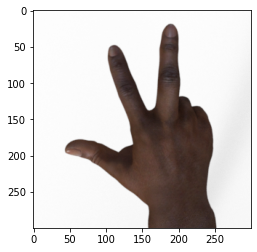

In [ ]:
rgb_images = np.array([example['image'].numpy() for example in ds_train])

plt.imshow(rgb_images[0])

In [ ]:
rgb_images.shape

(2520, 300, 300, 3)

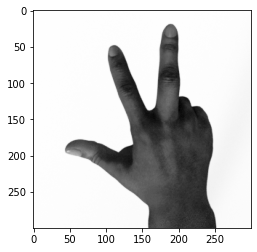

In [ ]:
gray_image = train_images[0].reshape(300,300)
plt.imshow(gray_image,cmap='Greys_r')

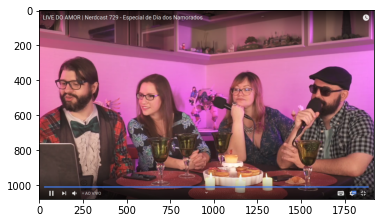

In [ ]:
import imageio

img = imageio.imread('/content/drive/My Drive/Colab Notebooks/neural-nets-master/imagem.png')

plt.imshow(img)

In [ ]:
np.asarray(img).shape

(1080, 1920, 4)